In [1]:
import warnings
from typing import Dict, Union

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.preprocessing import StandardScaler

### Example data for GSE90014 (human single-cell dataset of reprogrammed cells)

data_example: raw count matrix where row indices are gene names and column names are samples


In [2]:
data = pd.read_csv("../output_reprogramming/example_vst.csv.gz", index_col=0)

data = data.T

### Metadata

metadata is manually curated and should include columns 'days_of_reprogramming' and 'cell_type'. In 'days_of_reprogramming', each sample should have numeric values, except for iPSC samples, which retain the string 'iPSC'.


In [3]:
metadata = pd.read_csv(
    "../data_example_reprogramming/example_metadata.csv", index_col=0
)

### Hallmarks

In [4]:
senescence = pd.read_csv("../../../signatures/output_data_signatures/senescence_data.csv")
autophagy = pd.read_csv(
    "../../../signatures/output_data_signatures/autophagy_signatures.csv"
)
genomic = pd.read_csv(
    "../../../signatures/output_data_signatures/genomic_signatures_new.csv"
)
proteostasis = pd.read_csv(
    "../../../signatures/output_data_signatures/proteostasis_signatures.csv"
)
all_genes = pd.read_csv(
    "../../../signatures/output_data_signatures/all_hallmarks.csv", index_col=0
)

### Adding mouse genes for working with mouse datasets

In [5]:
human_to_mouse = dict(zip(all_genes["ENSEMBL"], all_genes["ENSEMBL_mice"]))


def add_mouse_column(df):
    df["ENSEMBL_mice"] = df["ENSEMBL"].map(human_to_mouse)
    return df


senescence = add_mouse_column(senescence)
autophagy = add_mouse_column(autophagy)
genomic = add_mouse_column(genomic)
proteostasis = add_mouse_column(proteostasis)

### Plotting trajectories by categories (senescence, autophagy, genomic, proteostasis)

In [6]:
def plot_subprocess_trends(
    data: pd.DataFrame,
    genes: pd.DataFrame,
    metadata: pd.DataFrame,
    ensembl_column: str = "ENSEMBL",
    name_subpocess: str = "name_subpocess",
) -> None:
    """
    Plots aggregated expression trends for subprocesses using Z-score normalization and PCA.

    Parameters:
        data : pd.DataFrame
            DataFrame of gene expression values with a time column (metadata['days_of_reprogramming']).
        genes : pd.DataFrame
            DataFrame of gene annotations, containing a subprocess column and a gene identifier column.
        metadata : pd.DataFrame
            DataFrame of metadata, including the 'days_of_reprogramming' column.
        ensembl_column : str
            Name of the column in `genes` that holds ENSEMBL identifiers
            (for example, 'ENSEMBL' or 'ENSEMBL_mice').
        name_subpocess : str
            Label to use for the subprocess on the plot.

    Returns:
        None. Displays the trend plot.
    """

    warnings.filterwarnings("ignore")

    temp = data.copy()
    temp["day"] = metadata["days_of_reprogramming"]
    temp["day"] = temp["day"].replace("iPSC", np.nan)
    temp["day"] = pd.to_numeric(temp["day"], errors="coerce")
    max_day = temp["day"].max()
    temp["day"] = temp["day"].fillna(max_day + 1)
    temp = temp.dropna(subset=["day"])
    temp = temp.sort_values("day")
    days = temp.pop("day").values.astype(float)
    time_grid = np.sort(np.unique(days))

    gpr_results: dict[str, np.ndarray] = {}
    for gene_id in genes[ensembl_column].dropna().unique():
        if gene_id not in temp.columns:
            continue
        y = temp[gene_id].values
        X = days.reshape(-1, 1)
        kernel = Matern(length_scale=5.0) + WhiteKernel(noise_level=1.0)
        gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        try:
            gpr.fit(X, y)
            y_mean, _ = gpr.predict(time_grid.reshape(-1, 1), return_std=True)
            gpr_results[gene_id] = y_mean
        except Exception:
            continue

    subprocess_trends: dict[str, dict[str, np.ndarray | float]] = {}
    for subprocess in genes["Subprocess"].dropna().unique():
        gene_ids = genes.loc[genes["Subprocess"] == subprocess, ensembl_column]
        gene_ids = [g for g in gene_ids if g in gpr_results]
        if len(gene_ids) < 3:
            continue
        expr_mat = pd.DataFrame({g: gpr_results[g] for g in gene_ids}, index=time_grid)

        zmat = pd.DataFrame(
            StandardScaler().fit_transform(expr_mat),
            index=expr_mat.index,
            columns=expr_mat.columns,
        )

        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(zmat)[:, 0]
        subprocess_trends[subprocess] = {
            "PC1_zscore": pc1,
            "expl_var": float(pca.explained_variance_ratio_[0]),
        }

    raw_days = metadata["days_of_reprogramming"].dropna().unique().tolist()
    xticks: list[float] = []
    xticklabels: list[str] = []
    for val in raw_days:
        if isinstance(val, str) and val.lower() == "ipsc":
            xticks.append(time_grid[-1])
            xticklabels.append("iPSC")
        else:
            num = float(val)
            xticks.append(num)
            xticklabels.append(str(int(num)))

    cmap = get_cmap("tab20")
    plt.figure(figsize=(14, 7))
    for idx, (subprocess, res) in enumerate(subprocess_trends.items()):
        plt.plot(
            time_grid,
            res["PC1_zscore"],
            label=f"{subprocess} (PC1, {res['expl_var']:.1%})",
            color=cmap(idx % 20),
        )
    plt.xlabel("Days of reprogramming")
    plt.ylabel("PC1 (Z-scored expression)")
    plt.title(f"Aggregated expression trends by {name_subpocess} (Z-score + PCA)")
    plt.xticks(ticks=xticks, labels=xticklabels)
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.savefig(
        "../output_reprogramming/aggregated_trends.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

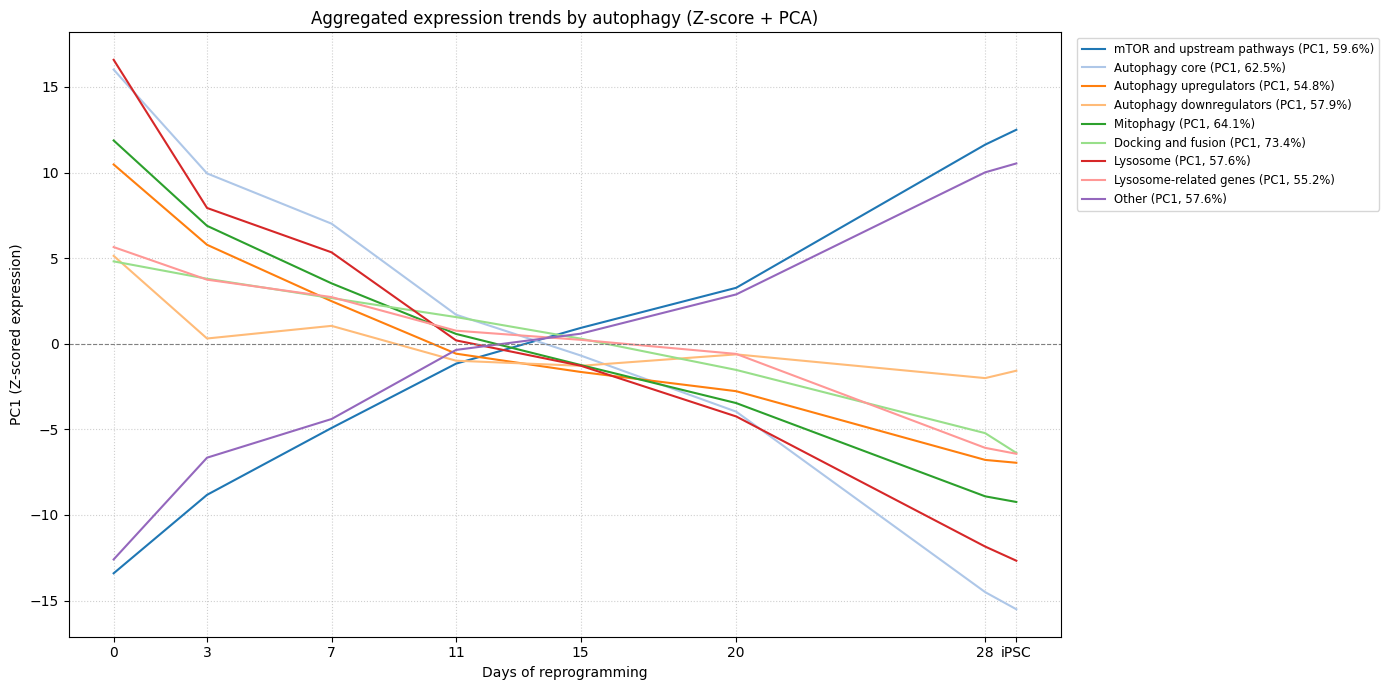

In [7]:
plot_subprocess_trends(data, autophagy, metadata, "ENSEMBL", "autophagy")